<a href="https://colab.research.google.com/github/pinilDissanayaka/Ayurvedic-Plant-Classification/blob/main/XceptionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 34.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
! kaggle datasets download yasht26/ayurvedic-plants

Dataset URL: https://www.kaggle.com/datasets/yasht26/ayurvedic-plants
License(s): MIT
100% 2.99G/2.99G [03:07<00:00, 20.2MB/s]
100% 2.99G/2.99G [03:07<00:00, 17.2MB/s]


In [5]:
! unzip /content/ayurvedic-plants.zip

Streaming output truncated to the last 5000 lines.
  inflating: medicinalplant/Rasna/Rasna_001.png  
  inflating: medicinalplant/Rasna/Rasna_002.png  
  inflating: medicinalplant/Rasna/Rasna_003.png  
  inflating: medicinalplant/Rasna/Rasna_004.png  
  inflating: medicinalplant/Rasna/Rasna_005.png  
  inflating: medicinalplant/Rasna/Rasna_006.png  
  inflating: medicinalplant/Rasna/Rasna_007.png  
  inflating: medicinalplant/Rasna/Rasna_008.png  
  inflating: medicinalplant/Rasna/Rasna_009.png  
  inflating: medicinalplant/Rasna/Rasna_010.png  
  inflating: medicinalplant/Rasna/Rasna_011.png  
  inflating: medicinalplant/Rasna/Rasna_012.png  
  inflating: medicinalplant/Rasna/Rasna_013.png  
  inflating: medicinalplant/Rasna/Rasna_014.png  
  inflating: medicinalplant/Rasna/Rasna_015.png  
  inflating: medicinalplant/Rasna/Rasna_016.png  
  inflating: medicinalplant/Rasna/Rasna_017.png  
  inflating: medicinalplant/Rasna/Rasna_018.png  
  inflating: medicinalplant/Rasna/Rasna_019.png  

In [7]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import cv2
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from livelossplot import PlotLossesKeras

import warnings
warnings.filterwarnings(action = 'ignore')

In [17]:
import glob
from pathlib import Path

main_path = '/content/medicinalplant'

In [23]:
for path in glob.glob(main_path + '/*'):
    print(f"{os.path.basename(path)} : {len(glob.glob(path + '/*'))}")

Jamaica_Cherry-Gasagase : 500
Indian_Mustard : 500
Parijata : 500
Rasna : 500
Lemon : 500
Tamarind : 500
Roxburgh_fig : 500
Coriender : 500
Sandalwood : 500
Tulsi : 500
Mint : 500
Insulin : 500
Pomegranate : 500
Neem : 500
Oleander : 500
Marigold : 500
Jasmine : 500
Palak(Spinach) : 500
ashoka : 500
Crape_Jasmine : 500
Fenugreek : 500
Bhrami : 500
Amla : 500
Honge : 500
Rose : 500
Seethapala : 500
Basale : 500
Turmeric : 500
Drumstick : 500
Aloevera : 500
Betel : 500
Papaya : 500
Arive-Dantu : 500
Rose_apple : 500
Jamun : 500
Hibiscus : 500
Jackfruit : 500
Karanda : 500
Henna : 500
Peepal : 500
Indian_Beech : 500
Mango : 500
Guava : 500
Mexican_Mint : 500
Curry : 500


In [25]:
SEED = 123
EPOCHS = 100
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(main_path + '/*'))
print(n_classes)

45


In [27]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(main_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

test_datagen = generator.flow_from_directory(main_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)


print(train_datagen.class_indices)
print(train_datagen.samples, test_datagen.samples )

Found 18000 images belonging to 45 classes.
Found 4500 images belonging to 45 classes.
{'Aloevera': 0, 'Amla': 1, 'Arive-Dantu': 2, 'Basale': 3, 'Betel': 4, 'Bhrami': 5, 'Coriender': 6, 'Crape_Jasmine': 7, 'Curry': 8, 'Drumstick': 9, 'Fenugreek': 10, 'Guava': 11, 'Henna': 12, 'Hibiscus': 13, 'Honge': 14, 'Indian_Beech': 15, 'Indian_Mustard': 16, 'Insulin': 17, 'Jackfruit': 18, 'Jamaica_Cherry-Gasagase': 19, 'Jamun': 20, 'Jasmine': 21, 'Karanda': 22, 'Lemon': 23, 'Mango': 24, 'Marigold': 25, 'Mexican_Mint': 26, 'Mint': 27, 'Neem': 28, 'Oleander': 29, 'Palak(Spinach)': 30, 'Papaya': 31, 'Parijata': 32, 'Peepal': 33, 'Pomegranate': 34, 'Rasna': 35, 'Rose': 36, 'Rose_apple': 37, 'Roxburgh_fig': 38, 'Sandalwood': 39, 'Seethapala': 40, 'Tamarind': 41, 'Tulsi': 42, 'Turmeric': 43, 'ashoka': 44}
18000 4500


In [29]:
def create_model(input_size, n_classes):
    back_bone = tf.keras.applications.Xception(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy

    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 45)                  │          92,205 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,953,685 (79.93 MB)

 Trainable params: 20,899,157 (79.72 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [31]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='xception.weights.best.keras',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

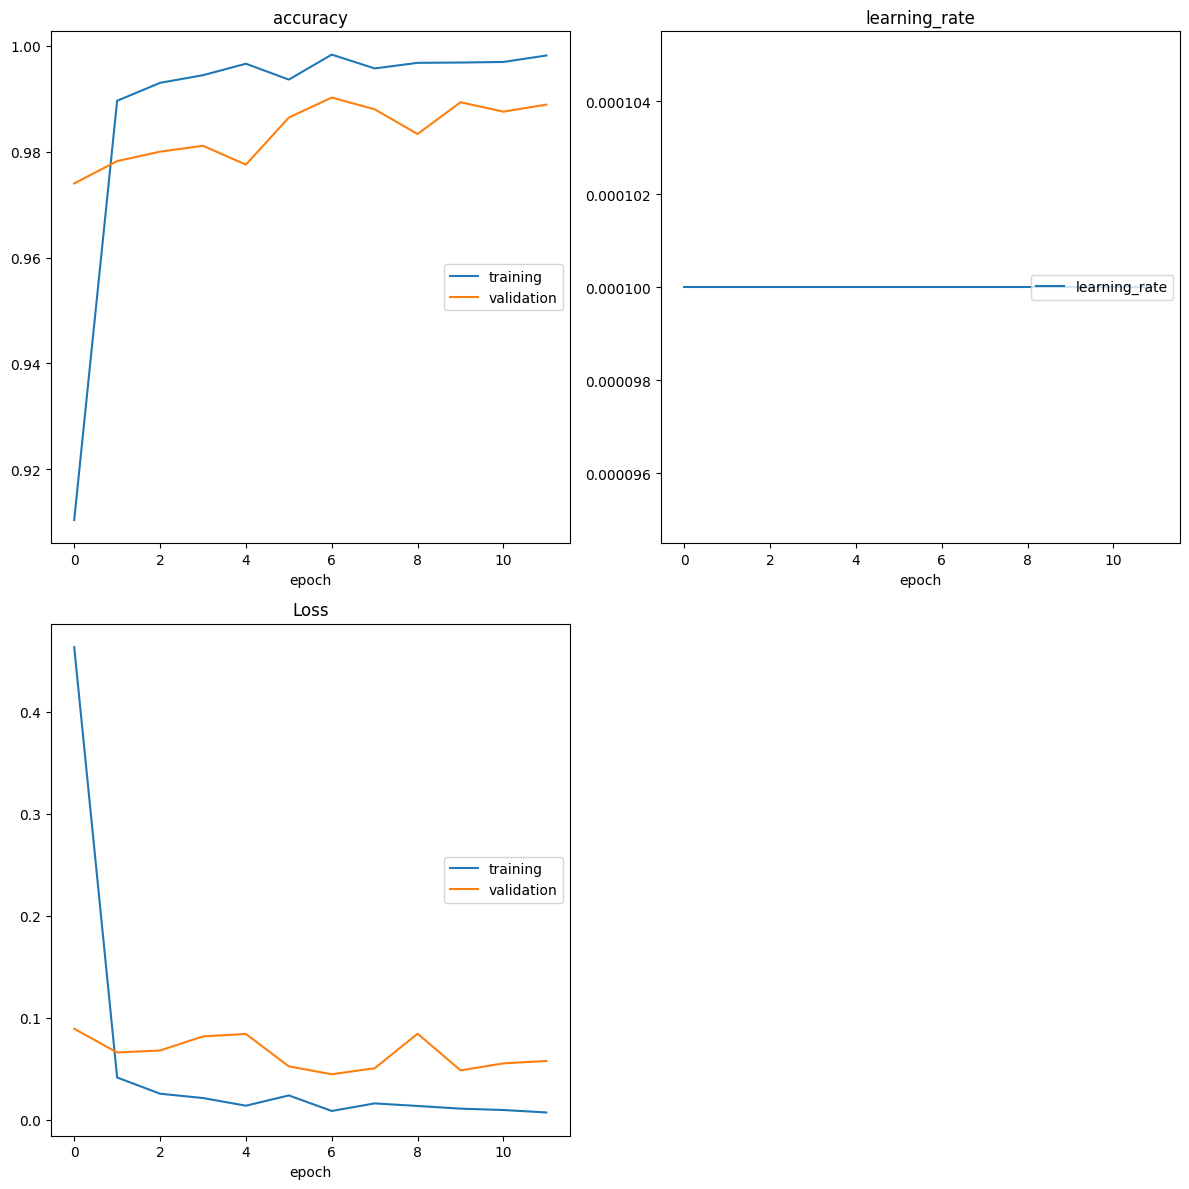

accuracy
	training         	 (min:    0.910, max:    0.998, cur:    0.998)
	validation       	 (min:    0.974, max:    0.990, cur:    0.989)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.007, max:    0.463, cur:    0.007)
	validation       	 (min:    0.045, max:    0.089, cur:    0.058)
563/563 ━━━━━━━━━━━━━━━━━━━━ 583s 1s/step - accuracy: 0.9980 - loss: 0.0077 - val_accuracy: 0.9889 - val_loss: 0.0577 - learning_rate: 1.0000e-04
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


In [32]:
history = model.fit(train_datagen,
                    validation_data=test_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint, PlotLossesKeras()])

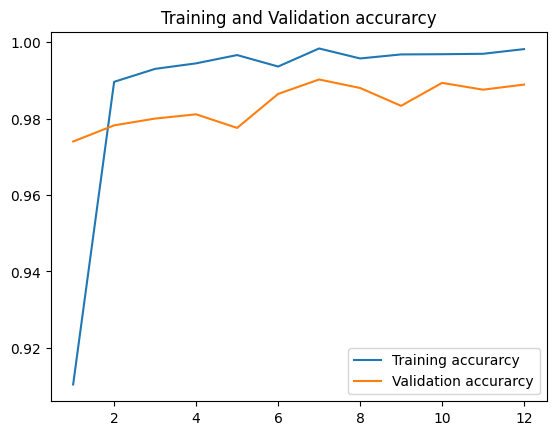

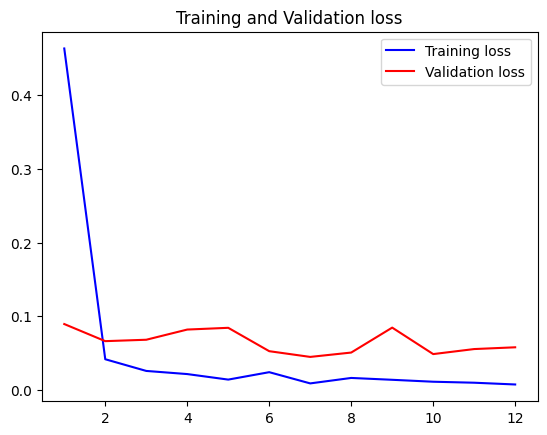

CPU times: user 526 ms, sys: 108 ms, total: 634 ms
Wall time: 605 ms


In [33]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_xception_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [60]:
STEP_SIZE_TEST=test_datagen.n//test_datagen.batch_size
#test_generator.reset()

model.load_weights('/content/xception.weights.best.keras')
pred = model.predict(test_datagen,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

pred_classes = np.argmax(pred, axis=1)

140/140 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step


In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_datagen.class_indices.keys()
true_classes = test_datagen.classes[:len(pred_classes)]

acc = accuracy_score(true_classes, pred_classes)

print("xception Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

xception Model Accuracy : 1.90%
                         precision    recall  f1-score   support

               Aloevera    0.02041   0.02000   0.02020       100
                   Amla    0.05882   0.05000   0.05405       100
            Arive-Dantu    0.03000   0.03000   0.03000       100
                 Basale    0.00000   0.00000   0.00000       100
                  Betel    0.00000   0.00000   0.00000       100
                 Bhrami    0.02020   0.02000   0.02010       100
              Coriender    0.03030   0.03000   0.03015       100
          Crape_Jasmine    0.00980   0.01000   0.00990       100
                  Curry    0.01000   0.01000   0.01000       100
              Drumstick    0.01031   0.01000   0.01015       100
              Fenugreek    0.05051   0.05000   0.05025       100
                  Guava    0.01000   0.01000   0.01000       100
                  Henna    0.03030   0.03000   0.03015       100
               Hibiscus    0.01000   0.01000   0.01000   

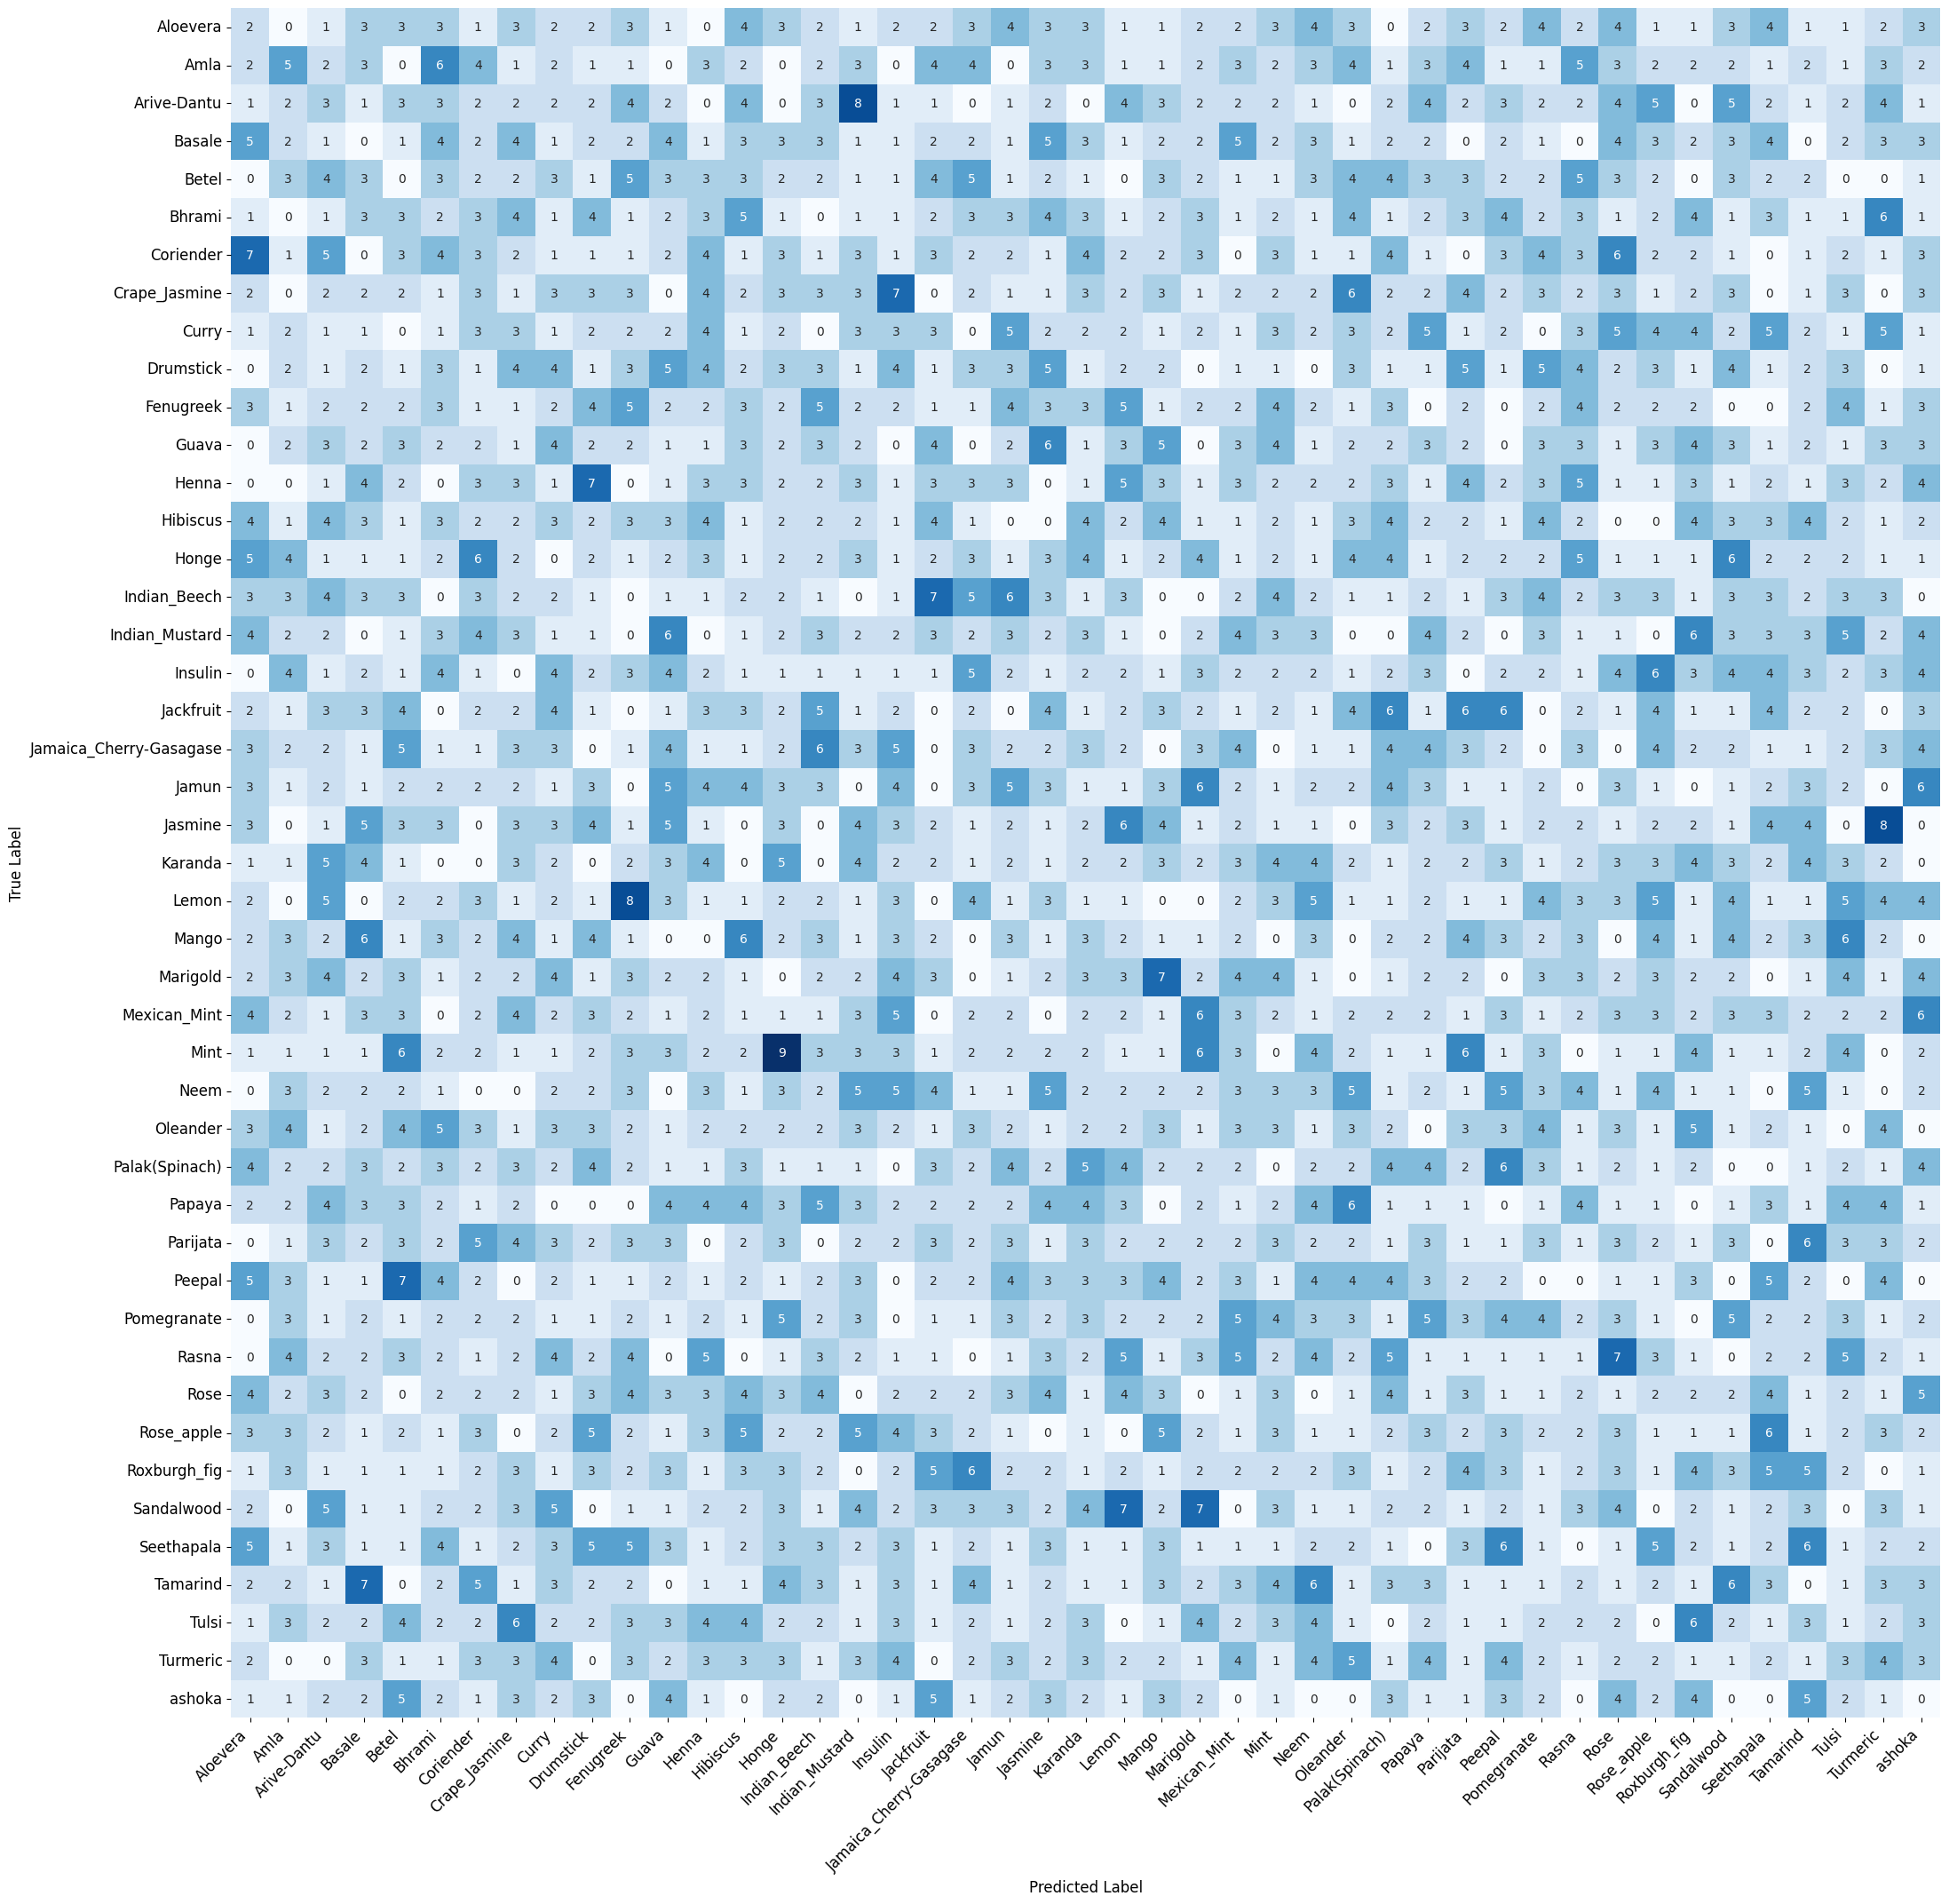

[[2 0 1 ... 1 2 3]
 [2 5 2 ... 1 3 2]
 [1 2 3 ... 2 4 1]
 ...
 [1 3 2 ... 1 2 3]
 [2 0 0 ... 3 4 3]
 [1 1 2 ... 2 1 0]]


In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_datagen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(25, 25))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [68]:
loss, acc = model.evaluate(test_datagen, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

140/140 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9905 - loss: 0.0387
0.9897321462631226 0.04257017746567726


In [69]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_datagen.class_indices)

labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
Honge,108
Rose,107
Jasmine,106
Karanda,103
Crape_Jasmine,102
ashoka,101
Lemon,101
Hibiscus,100
Arive-Dantu,100
Turmeric,100


In [70]:
from tensorflow.keras.models import save_model
save_model(model, "model.h5")

In [71]:
from tensorflow.keras.models import load_model

# load model
model1 = load_model('model.h5')

In [74]:
import pickle

# save the model to disk
filename = 'labels.pkl'
with open(filename, 'wb') as file:
  pickle.dump(labels, file)